# Samples analysis
Analyse cosmological model posterior samples.

In [1]:
import os; os.environ['XLA_PYTHON_CLIENT_MEM_FRACTION']='.40' # NOTE: jax preallocates GPU (default 75%)
import matplotlib.pyplot as plt
import numpy as np
from jax import numpy as jnp, random as jr, config as jconfig, jit, vmap, grad, debug, tree
# jconfig.update("jax_enable_x64", True)

from functools import partial
from getdist import plots
from numpyro import infer

from montecosmo.model import FieldLevelModel, default_config
from montecosmo.utils import pdump, pload
from montecosmo.mcbench import sample_and_save
from montecosmo.script import from_id, get_mcmc, get_init_mcmc

# import mlflow
# mlflow.set_tracking_uri(uri="http://127.0.0.1:8081")
# mlflow.set_experiment("infer")
# !jupyter nbconvert --to script ./src/montecosmo/tests/infer_model.ipynb

%matplotlib inline
%load_ext autoreload
%autoreload 2

## What are Chains?
### Chains object is a PyTree made of a data, and optional metadata as groups and labels:
* `data` is a dict of arrays, of arbitrary dimensions.
* `groups` is a dict of list of strings, that serve as alias for fast querying and gathering.
* `labels` is a dict of strings used for plots.

### Chains has classical properties:
* `shape`, `ndim`, `dtype`, `size`...
* they can be merged with other Chains, dict, and UserDict using pipe `|`.

### Chains allows variety of keys for easy querying:
* **slicing and indexing**: `chains[3,1::2]`
* **querying values**:

    ```python
    data = {'a':0,'b':1,'c':2}
    groups = {'ab':['a','b']}
    chains = Chains(data, groups)

    # Query by data key or groups
    assert chains['c','ab'] == (2, 0, 1) # 'ab' is an alias for 'a','b'

    # Special keys everything '*', minus '~', and everything minus '*~' 
    assert chains['*~ab'] == 2 # everything minus group 'ab'
    assert chains['*','~c'] == (0, 1) # everything minus 'c'

    # Keys are parsed in given order
    assert chains['~c','*'] == (0, 1, 2) # minus 'c' (empty tuple) plus everything
    ```
* **querying subchains** (as in `panda` but allows non-tabular data):
    ```python
    data = {'a':0,'b':1,'c':2}
    groups = {'ab':['a','b']}
    chains = Chains(data, groups)

    # Query by data key or groups
    ch0, ch1 = chains[['ab'],['c']] # split into subchains
    assert ch0.data == {'a': 0, 'b': 1}

    # Special keys everything '*', minus '~', and everything minus '*~' 
    ch0, ch1 = chains[['*~c'],['c']] # split into subchains
    assert ch1.data == {'c': 2}

    # Mix value and subchain querying
    ch0, v1 = chains[['ab'],'c']
    assert v1 == 2
    ```
### Chains can be transformed:
* chains can be `tree.map`ped
* chains can be stacked by groups, flatten, concatenated...
* chains transforms can themselves be applied on axes splits or cumulatively along axes.
* chains can be plotted, or cast to `getdist`.

## Example

In [ ]:
from montecosmo.model import FieldLevelModel, default_config
from montecosmo.mcbench import Chains
save_dir = '/feynman/home/dphp/hs276503/scratch/pickles/m32_b160.0_al0.5_ao0.5_lo1_pc3_obfield/'
save_path = save_dir + 'sNUTS_nc4_ns2_mt10_ta0.65'
model = FieldLevelModel.load(save_dir+'model.p')
truth = pload(save_dir+'truth.p') 

transforms = [
              lambda x:x[['*~diverging']], 
              partial(Chains.thin, thinning=1),
              model.reparam_chains, 
              partial(Chains.choice, n=10, names=['init','init_']),
              ]
chains = model.load_runs(save_path, 0, 11, transforms=transforms, batch_ndim=2)
names = ['cosmo','bias','init']
chains.shape

Loading: sNUTS_nc4_ns2_mt10_ta0.65, from run 0 to run 11 (included)
File /feynman/home/dphp/hs276503/scratch/pickles/m32_b160.0_al0.5_ao0.5_lo1_pc3_obfield/sNUTS_nc4_ns2_mt10_ta0.65_7.npz does not exist, stopping at run 6


/feynman/work/dphp/hs276503/envs/montenvtest3/lib/python3.12/site-packages/jax/_src/numpy/array_methods.py:66: UserWarning: Explicitly requested dtype <class 'jax.numpy.int64'> requested in astype is not available, and will be truncated to dtype int32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  return lax_numpy.astype(arr, dtype)


ValueError: Cannot take a larger sample than population when 'replace=False'

In [43]:
chains.flatten().shape

{'Omega_m': (4, 14),
 'b1': (4, 14),
 'b2': (4, 14),
 'bn2': (4, 14),
 'bs2': (4, 14),
 'init_mesh[0]': (4, 14),
 'init_mesh[1]': (4, 14),
 'init_mesh[2]': (4, 14),
 'init_mesh[3]': (4, 14),
 'init_mesh[4]': (4, 14),
 'init_mesh[5]': (4, 14),
 'init_mesh[6]': (4, 14),
 'init_mesh[7]': (4, 14),
 'init_mesh[8]': (4, 14),
 'init_mesh[9]': (4, 14),
 'n_evals': (4, 14),
 'sigma8': (4, 14)}


                  mean       std    median      5.0%     95.0%     n_eff     r_hat
     Omega_m      0.30      0.05      0.31      0.24      0.39     25.75      1.10
          b1      1.01      0.07      1.00      0.90      1.13      5.13      1.49
          b2     -0.01      0.04     -0.01     -0.08      0.05      5.35      1.45
         bn2      0.56      0.48      0.57     -0.11      1.33     13.89      1.37
         bs2      0.05      0.19      0.02     -0.19      0.41      6.25      1.38
init_mesh[0]     -0.15      1.20     -0.13     -2.01      1.61    234.79      0.96
init_mesh[1]     -0.85      1.07     -0.84     -2.38      0.82     54.04      1.01
init_mesh[2]      1.28      2.04      1.51     -1.17      5.31     90.72      0.99
init_mesh[3]     -0.25      1.28     -0.07     -2.89      1.26     97.94      0.98
init_mesh[4]      0.16      1.26      0.30     -1.94      1.98     61.42      0.95
init_mesh[5]     -0.86      1.25     -0.84     -2.70      1.15    181.47      0.98
ini

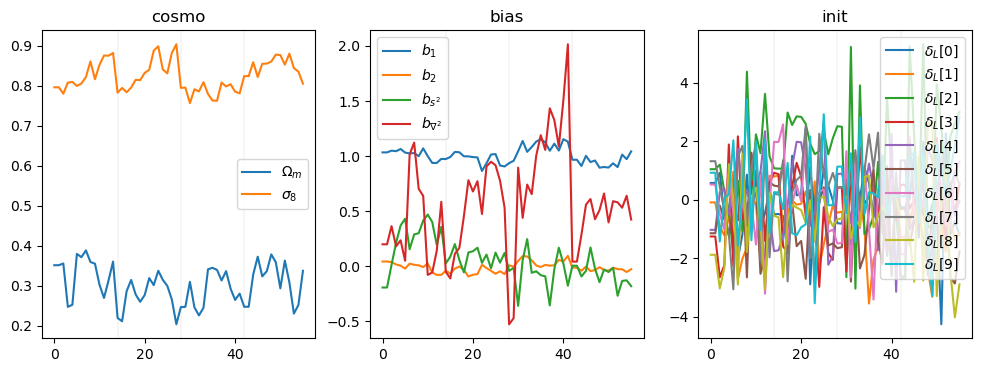

In [41]:
plt.figure(figsize=(12,4))
chains.flatten().plot(names, batch_ndim=2)
chains.print_summary()

Removed no burn in


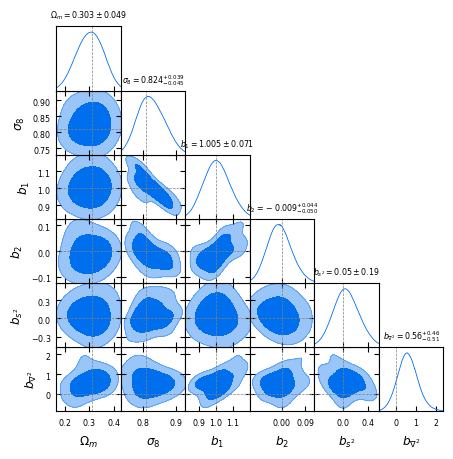

In [33]:
gdsamp = chains[['cosmo','bias']].to_getdist()

gdplt = plots.get_subplot_plotter(width_inch=5)
gdplt.triangle_plot(roots=[gdsamp],
                title_limit=1,
                filled=True, 
                markers=truth,)

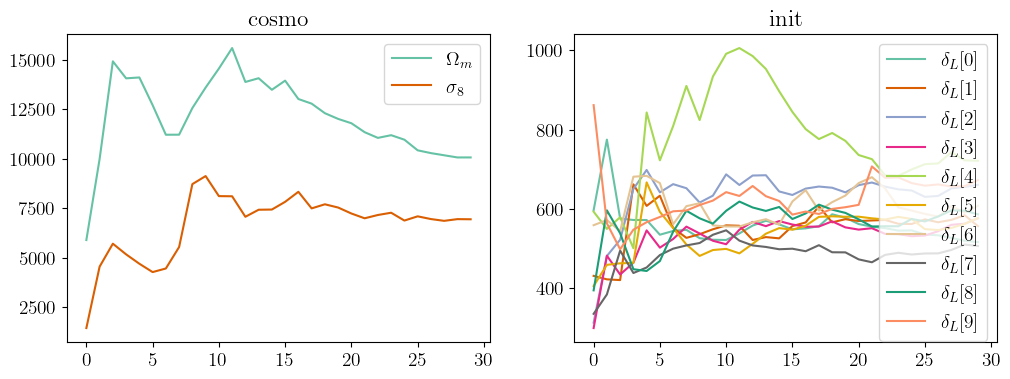

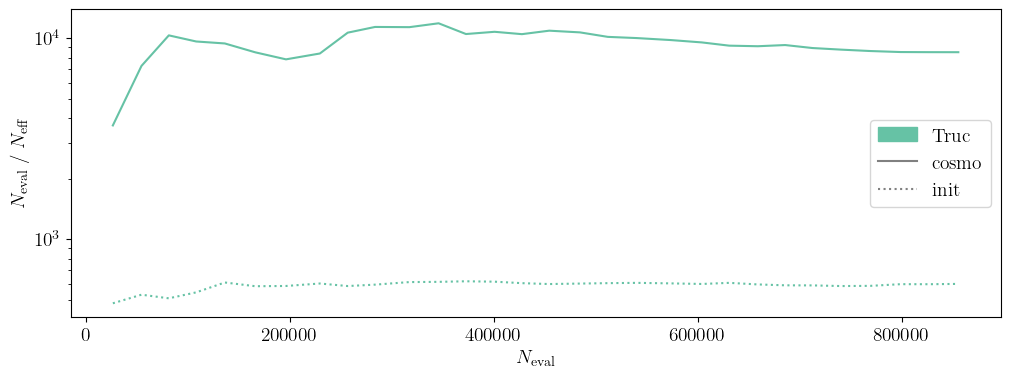

In [ ]:
from montecosmo.plot import theme, SetDark2
theme(usetex=True, font_size=14)
plt.figure(figsize=(12, 4))
chains.flatten().cumtrans(Chains.eval_per_ess, 30).plot(names, 1)
plt.tight_layout()

metrics = []
cumess = chains.stackby(names).cumtrans(Chains.eval_per_ess, 30)
metrics.append(cumess)

def plot_fn():
    plt.figure(figsize=(12, 4))
    methods = ['Truc']
    i_start = 0
    styles = ['-', ':', '--']
    for i_m, (metric, meth) in enumerate(zip(metrics, methods)):
        for i_g, (st, g) in enumerate(zip(styles, names)):
            plt.semilogy(metric['n_evals'][i_start:], metric[g][i_start:], st, c=SetDark2(i_m), label=g)

    from matplotlib.lines import Line2D; from matplotlib.patches import Patch
    handles = []
    for i_m, method in enumerate(methods):
        handles.append(Patch(color=SetDark2(i_m), label=method))
    for i_g, g in enumerate(names):
        handles.append(Line2D([], [], color='grey', linestyle=styles[i_g], label=g))

    plt.legend(handles=handles);

plot_fn()
plt.xlabel("$N_{\\mathrm{eval}}$")
# plt.ylabel("$N_{\\mathrm{eval}}\\;/\\;\\mathrm{ESS}$")
plt.ylabel("$N_{\\mathrm{eval}}\\;/\\;N_{\\mathrm{eff}}$")
plt.tight_layout();

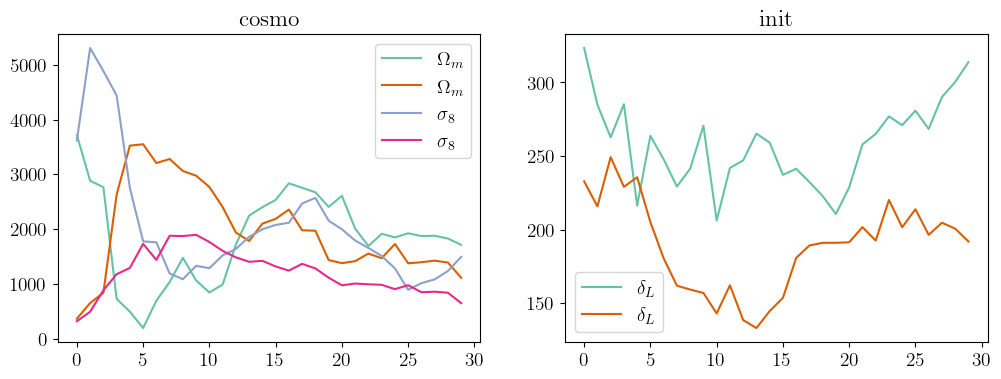

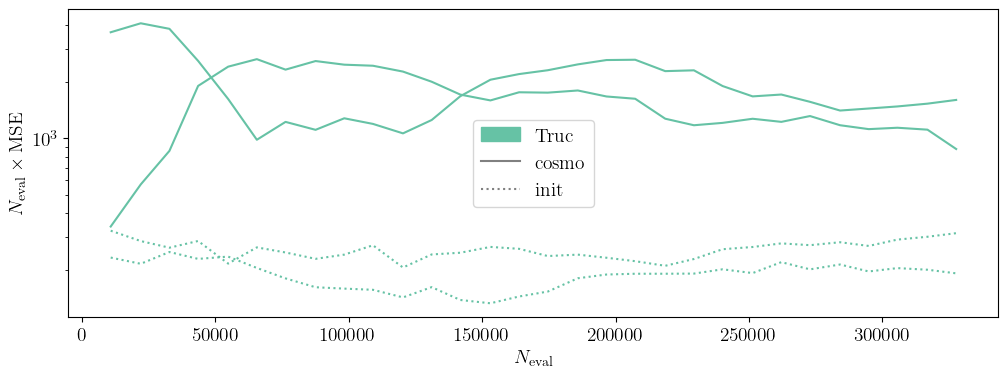

In [ ]:
plt.figure(figsize=(12, 4))
true_cmom = chains.moment(axis=(0,1)).center_moment()
fn = lambda x: Chains.eval_times_mse(x, true_cmom)
chains.cumtrans(fn, 30).plot(names, 1)
plt.tight_layout()

metrics = []
true_cmom = chains.stackby(names).moment(axis=(0,1)).center_moment()
fn = lambda x: Chains.eval_times_mse(x, true_cmom)
cummse = chains.stackby(names).cumtrans(fn, 30)
metrics.append(cummse)

plot_fn()
plt.xlabel("$N_{\\mathrm{eval}}$")
plt.ylabel("$N_{\\mathrm{eval}} \\times \\mathrm{MSE}$")
plt.tight_layout();

<Figure size 1200x400 with 0 Axes>

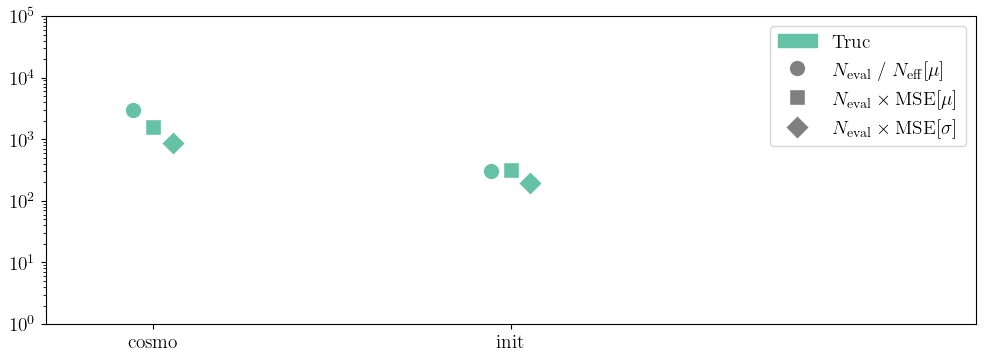

In [ ]:
from montecosmo.plot import theme, SetDark2
theme(usetex=True, font_size=14)
plt.figure(figsize=(12, 4))

metrics = []
cumess = chains.stackby(names).eval_per_ess()
cummse = chains.stackby(names).eval_times_mse(true_cmom)
metric = tree.map(lambda x, y: jnp.concatenate((x[None], y)), cumess[['*~n_evals']], cummse[['*~n_evals']])
metrics.append(metric)

plt.figure(figsize=(12, 4))
methods = ['Truc']
markers = ['o','s','D']
ms = 12
mec = 'w'
ls = ""
metric_names = [
                # "$N_{\\mathrm{eval}}\\;/\\;N_{\\mathrm{eff}}$",
                "$N_{\\mathrm{eval}}\\;/\\;N_{\\mathrm{eff}}[\\mu]$",
                "$N_{\\mathrm{eval}} \\times \\mathrm{MSE}[\\mu]$",
                "$N_{\\mathrm{eval}} \\times \\mathrm{MSE}[\\sigma]$"]

from matplotlib.transforms import ScaledTranslation
offset = lambda mm: ScaledTranslation(mm/25.4, 0, plt.gcf().dpi_scale_trans)
trans = plt.gca().transData
xshifts = 5*np.array([-1,0,1])
plt.xlim(-.3,2.3), plt.ylim((1e0, 1e5))

for i_m, (metric, meth) in enumerate(zip(metrics, methods)):
    for i_g, g in enumerate(names):
        for i_n, marker in enumerate(markers):
            plt.semilogy(g, metric[g][i_n], marker, c=SetDark2(i_m),
                         linestyle=ls, markersize=ms, markeredgecolor=mec, 
                         transform=trans+offset(xshifts[i_n])
                         )

handles = []
from matplotlib.lines import Line2D; from matplotlib.patches import Patch
for i_m, method in enumerate(methods):
    handles.append(Patch(color=SetDark2(i_m), label=method))
for i_m, (marker, name) in enumerate(zip(markers, metric_names)):
    handles.append(Line2D([], [], color='grey', marker=marker, label=name, 
                           linestyle=ls, markersize=ms, markeredgecolor=mec))

plt.legend(handles=handles, loc="upper right")
plt.tight_layout();

## Example


                  mean       std    median      5.0%     95.0%     n_eff     r_hat
     Omega_m      0.31      0.15      0.29      0.10      0.57     64.11      1.01
          b1      1.06      0.52      1.01      0.10      1.85     99.76      1.00
          b2      0.07      2.06      0.17     -3.59      2.94     89.42      1.00
         bn2     -0.30      1.78     -0.11     -3.40      2.19     87.39      1.00
         bs2      0.11      1.68     -0.02     -2.80      2.67    121.15      0.99
init_mesh[0]      0.10      1.70      0.25     -2.29      2.85    126.55      1.00
init_mesh[1]     -0.08      1.54     -0.13     -1.81      3.12    134.99      1.01
init_mesh[2]      0.07      1.59     -0.04     -2.74      2.50    119.47      0.98
init_mesh[3]     -0.11      1.49     -0.04     -2.75      1.88    207.53      1.00
init_mesh[4]     -0.05      1.81     -0.02     -2.85      3.22    127.23      0.99
init_mesh[5]     -0.33      1.46     -0.25     -2.38      2.12    113.33      0.99
ini

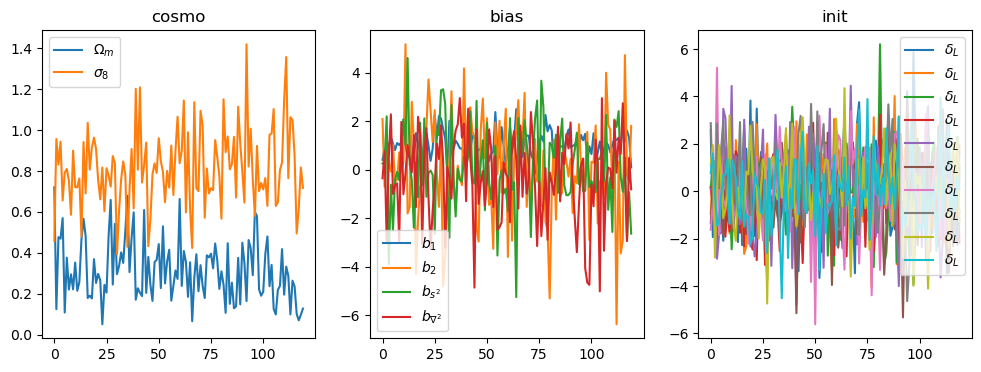

In [ ]:
plt.figure(figsize=(12,4))
chains.plot(names)
chains.print_summary()

Removed no burn in


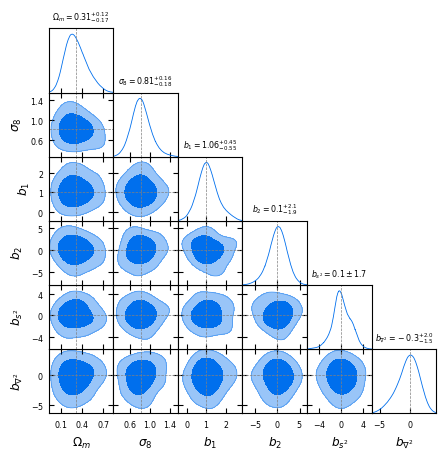

In [ ]:
gdsamp = chains[['cosmo','bias']].to_getdist()

gdplt = plots.get_subplot_plotter(width_inch=5)
gdplt.triangle_plot(roots=[gdsamp],
                title_limit=1,
                filled=True, 
                markers=truth,)

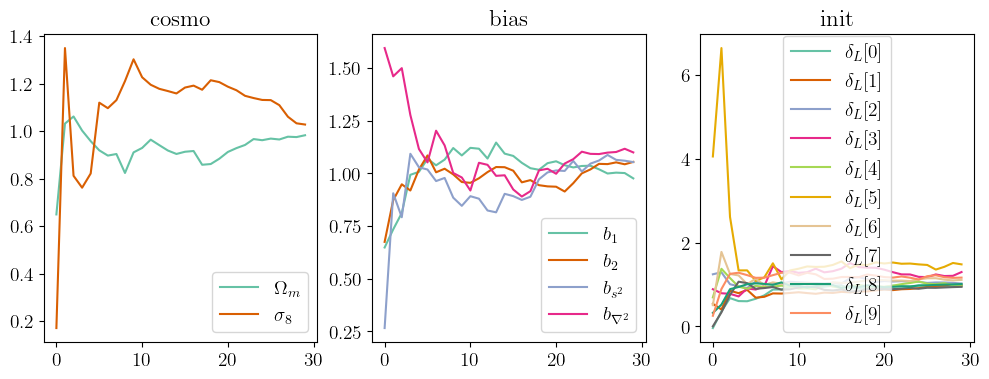

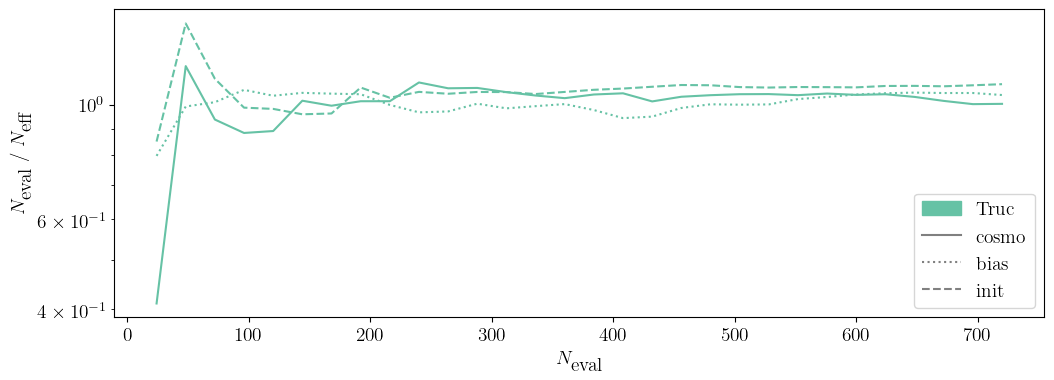

In [60]:
from montecosmo.plot import theme, SetDark2
theme(usetex=True, font_size=14)
plt.figure(figsize=(12, 4))
chains.flatten().cumtrans(Chains.eval_per_ess, 30).plot(names, 1)

metrics = []
cumess = chains.stackby(names).cumtrans(Chains.eval_per_ess, 30)
metrics.append(cumess)

def plot_fn():
    plt.figure(figsize=(12, 4))
    methods = ['Truc']
    i_start = 0
    styles = ['-', ':', '--']
    for i_m, (metric, meth) in enumerate(zip(metrics, methods)):
        for i_g, (st, g) in enumerate(zip(styles, names)):
            plt.semilogy(metric['n_evals'][i_start:], metric[g][i_start:], st, c=SetDark2(i_m), label=g)

    from matplotlib.lines import Line2D; from matplotlib.patches import Patch
    handles = []
    for i_m, method in enumerate(methods):
        handles.append(Patch(color=SetDark2(i_m), label=method))
    for i_g, g in enumerate(names):
        handles.append(Line2D([], [], color='grey', linestyle=styles[i_g], label=g))

    plt.legend(handles=handles);

plot_fn()
plt.xlabel("$N_{\\mathrm{eval}}$")
# plt.ylabel("$N_{\\mathrm{eval}}\\;/\\;\\mathrm{ESS}$")
plt.ylabel("$N_{\\mathrm{eval}}\\;/\\;N_{\\mathrm{eff}}$");

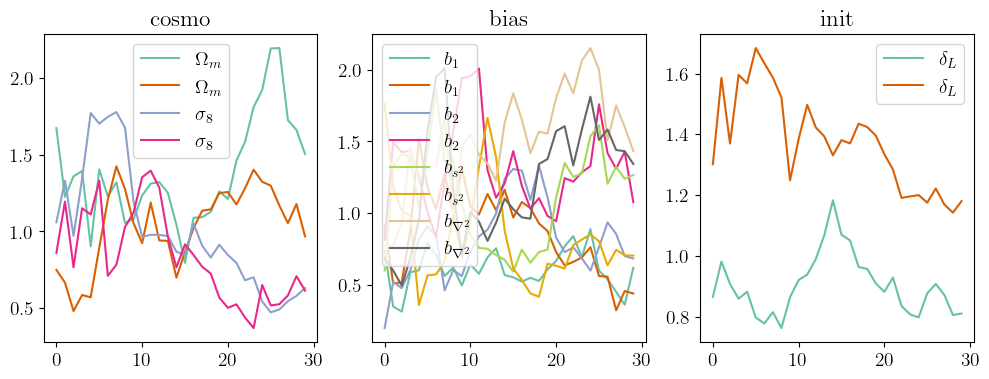

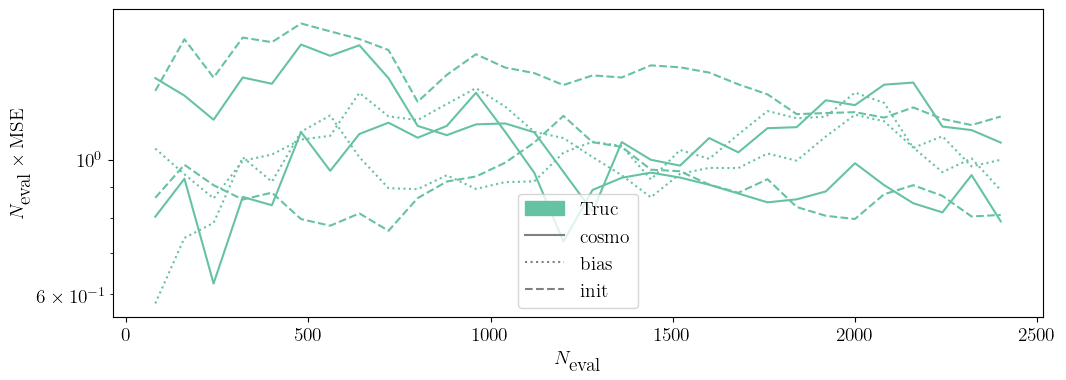

In [97]:
from montecosmo.plot import theme, SetDark2
theme(usetex=True, font_size=14)

plt.figure(figsize=(12, 4))
true_cmom = chains.moment(axis=(0,1)).center_moment()
fn = lambda x: Chains.eval_times_mse(x, true_cmom)
chains.cumtrans(fn, 30).plot(names, 1)

metrics = []
true_cmom = chains.stackby(names).moment(axis=(0,1)).center_moment()
fn = lambda x: Chains.eval_times_mse(x, true_cmom)
cummse = chains.stackby(names).cumtrans(fn, 30)
metrics.append(cummse)

plot_fn()
plt.xlabel("$N_{\\mathrm{eval}}$")
plt.ylabel("$N_{\\mathrm{eval}} \\times \\mathrm{MSE}$");

<Figure size 1200x400 with 0 Axes>

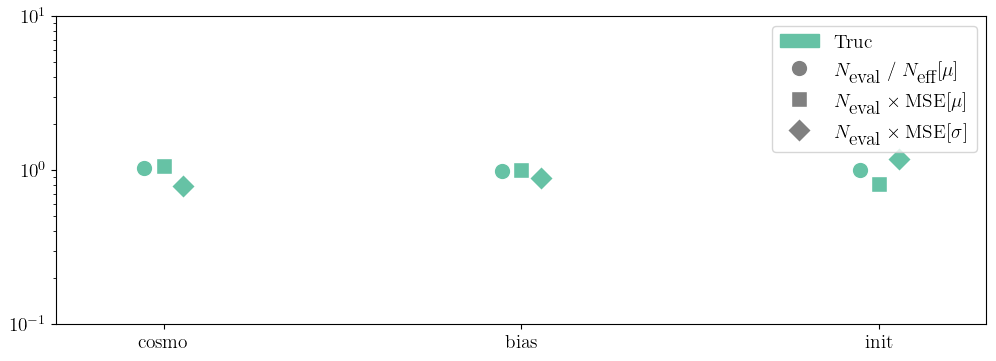

In [98]:
from montecosmo.plot import theme, SetDark2
theme(usetex=True, font_size=14)
plt.figure(figsize=(12, 4))

metrics = []
cumess = chains.stackby(names).eval_per_ess()
cummse = chains.stackby(names).eval_times_mse(true_cmom)
metric = tree.map(lambda x, y: jnp.concatenate((x[None], y)), cumess[['*~n_evals']], cummse[['*~n_evals']])
metrics.append(metric)

plt.figure(figsize=(12, 4))
methods = ['Truc']
markers = ['o','s','D']
ms = 12
mec = 'w'
ls = ""
metric_names = [
                # "$N_{\\mathrm{eval}}\\;/\\;N_{\\mathrm{eff}}$",
                "$N_{\\mathrm{eval}}\\;/\\;N_{\\mathrm{eff}}[\\mu]$",
                "$N_{\\mathrm{eval}} \\times \\mathrm{MSE}[\\mu]$",
                "$N_{\\mathrm{eval}} \\times \\mathrm{MSE}[\\sigma]$"]
# metric_names = ["ESS", "MSE[$\\mu$]", "MSE[$\\sigma$]"]

from matplotlib.transforms import ScaledTranslation
offset = lambda mm: ScaledTranslation(mm/25.4, 0, plt.gcf().dpi_scale_trans)
trans = plt.gca().transData
xshifts = 5*np.array([-1,0,1])
plt.xlim(-.3,2.3), plt.ylim((1e0, 1e5))

for i_m, (metric, meth) in enumerate(zip(metrics, methods)):
    for i_g, g in enumerate(names):
        for i_n, marker in enumerate(markers):
            plt.semilogy(g, metric[g][i_n], marker, c=SetDark2(i_m),
                         linestyle=ls, markersize=ms, markeredgecolor=mec, 
                         transform=trans+offset(xshifts[i_n])
                         )

handles = []
from matplotlib.lines import Line2D; from matplotlib.patches import Patch
for i_m, method in enumerate(methods):
    handles.append(Patch(color=SetDark2(i_m), label=method))
for i_m, (marker, name) in enumerate(zip(markers, metric_names)):
    handles.append(Line2D([], [], color='grey', marker=marker, label=name, 
                           linestyle=ls, markersize=ms, markeredgecolor=mec))

plt.legend(handles=handles, loc="upper right");

# Comparison

Loading truth from /feynman/home/dphp/hs276503/scratch/pickles/m64_b320.0_al0.5_ao0.5_lo1_pc3_obfield/
Loading: sNUTS_nc8_ns64_mt10_ta0.65, from run 0 to run 20 (included)
File /feynman/home/dphp/hs276503/scratch/pickles/m64_b320.0_al0.5_ao0.5_lo1_pc3_obfield/sNUTS_nc8_ns64_mt10_ta0.65_11.npz does not exist, stopping at run 10


/feynman/work/dphp/hs276503/envs/montenvtest3/lib/python3.12/site-packages/jax/_src/numpy/array_methods.py:66: UserWarning: Explicitly requested dtype <class 'jax.numpy.int64'> requested in astype is not available, and will be truncated to dtype int32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  return lax_numpy.astype(arr, dtype)


{'Omega_m': (8, 704), 'b1': (8, 704), 'b2': (8, 704), 'bn2': (8, 704), 'bs2': (8, 704), 'init_mesh': (8, 704, 10), 'n_evals': (8, 704), 'sigma8': (8, 704)}

                  mean       std    median      5.0%     95.0%     n_eff     r_hat
     Omega_m      0.33      0.02      0.33      0.30      0.37    120.67      1.05
          b1      1.00      0.04      1.00      0.94      1.07     65.05      1.12
          b2     -0.03      0.02     -0.03     -0.07      0.00    277.26      1.04
         bn2      0.25      0.24      0.25     -0.12      0.66     89.35      1.08
         bs2     -0.00      0.09     -0.00     -0.14      0.14    123.96      1.05
init_mesh[0]      2.42      1.35      2.38      0.14      4.57   3233.95      1.00
init_mesh[1]      0.39      1.36      0.37     -1.84      2.61   3144.17      1.00
init_mesh[2]      0.77      1.42      0.80     -1.55      3.14   2555.92      1.00
init_mesh[3]     -0.39      1.53     -0.36     -2.91      2.09   2396.89      1.00
init_mesh[4] 

/feynman/work/dphp/hs276503/envs/montenvtest3/lib/python3.12/site-packages/jax/_src/numpy/array_methods.py:66: UserWarning: Explicitly requested dtype <class 'jax.numpy.int64'> requested in astype is not available, and will be truncated to dtype int32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  return lax_numpy.astype(arr, dtype)


{'Omega_m': (8, 704), 'b1': (8, 704), 'b2': (8, 704), 'bn2': (8, 704), 'bs2': (8, 704), 'init_mesh': (8, 704, 10), 'n_evals': (8, 704), 'sigma8': (8, 704)}

                  mean       std    median      5.0%     95.0%     n_eff     r_hat
     Omega_m      0.33      0.02      0.33      0.30      0.37    110.58      1.06
          b1      1.00      0.05      1.00      0.92      1.07     80.55      1.11
          b2     -0.03      0.02     -0.03     -0.06      0.00    260.89      1.04
         bn2      0.24      0.25      0.24     -0.15      0.65    106.76      1.06
         bs2     -0.00      0.09     -0.01     -0.15      0.15    127.06      1.07
init_mesh[0]      2.42      1.35      2.37      0.28      4.67   3730.57      1.00
init_mesh[1]      0.35      1.37      0.37     -1.87      2.61   4532.20      1.00
init_mesh[2]      0.75      1.39      0.74     -1.44      3.10   3166.94      1.00
init_mesh[3]     -0.41      1.49     -0.37     -2.80      2.08   3101.56      1.00
init_mesh[4] 

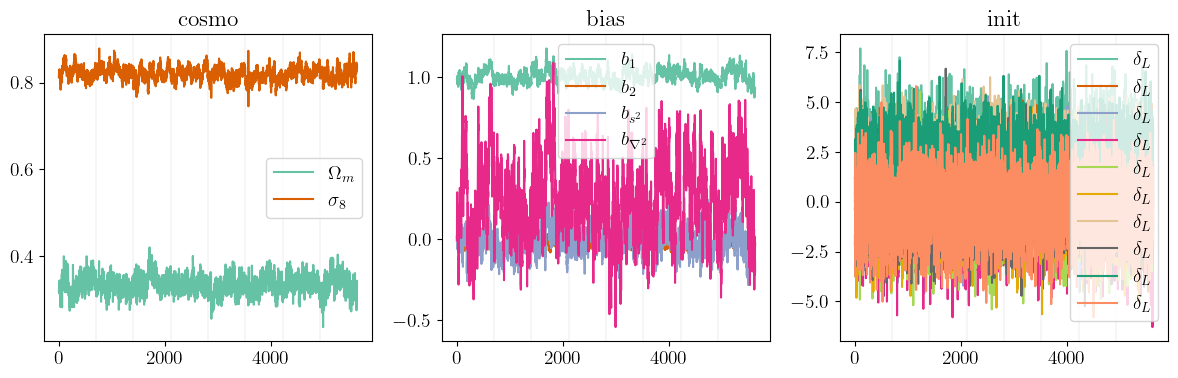

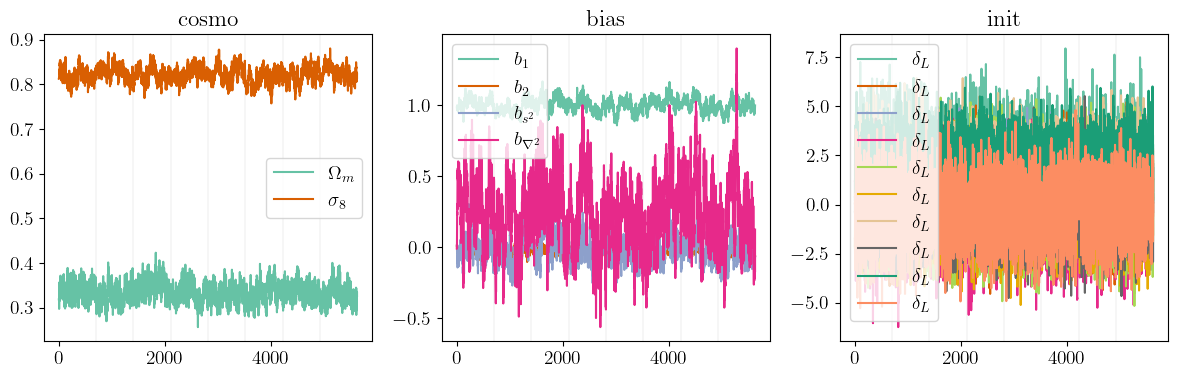

In [23]:
from montecosmo.mcbench import Chains
from montecosmo.plot import theme, SetDark2
theme(usetex=True, font_size=14)
names = ['cosmo','bias','init']

pfx = 'mm_nomm_'
tids = [3130,3130]
labels =['mm', 'no mm']

# pfx = 'precond_m64_lo0_'
# tids = [3000,3010,3020,3030]

# pfx = 'precond_m64_lo1_'
# tids = [3100,3110,3120,3130]
# labels = ['direct', 'prior', 'static', 'dynamic']

# pfx = 'sampler_m64_lo0_'
# tids = [3030,3031,3032]

# pfx = 'sampler_m64_lo1_'
# tids = [3130,3131,3132]
# labels = ['NUTS', 'HMC', 'NUTSwG']

starts = [0, 0, 0, 0]
end = 20

def load_fn(i_s, start, tid):
    model, mcmc_config, save_dir, save_path = from_id(tid)

    if i_s == 1:
        save_path += '_nomm'

    # Load truth
    print(f"Loading truth from {save_dir}")
    truth = pload(save_dir+"truth.p")
    model.delta_obs = truth['obs'] - 1

    # Load chains
    transforms = [
                lambda x: x[['*~diverging']],
                partial(Chains.thin, thinning=1), 
                model.reparam_chains, 
                partial(Chains.choice, n=10, names=['init','init_']),]
    chains = model.load_runs(save_path, start, end, transforms=transforms, batch_ndim=2)
    print(chains.shape)
    return model, truth, chains, save_dir


moms = []
for i_s, (start, tid, lab) in enumerate(zip(starts, tids, labels)):
    model, truth, chains, save_dir = load_fn(i_s, start, tid)

    # Load last state
    # last_state = pload(save_path + "_last_state.p")
    # print("mean_acc_prob:", last_state.mean_accept_prob, "\nss:", last_state.adapt_state.step_size)

    # Plot chains
    plt.figure(figsize=(12,4))
    chains.plot(['cosmo', 'bias','init'])
    plt.tight_layout()
    plt.savefig(save_dir+f'chains_{tid}.png')
    chains.print_summary()
    
    # Compute moments
    mom = chains.stackby(names).moment(axis=(0,1))
    moms.append(mom)

true_cmom = tree.map(lambda *x: jnp.stack(x), *moms)
true_cmom = true_cmom.moment(m=1, axis=0).center_moment()
print("centered moments:", true_cmom)

In [25]:
metrics = []
fin_metrics = []
gdsamps = []
for i_s, (start, tid, lab) in enumerate(zip(starts, tids, labels)):
    model, mcmc_config, save_dir, save_path = from_id(tid)
    model, truth, chains, save_dir = load_fn(i_s, start, tid)

    # Compute metrics
    cumess = chains.stackby(names).cumtrans(Chains.eval_per_ess, 50)
    metrics.append(cumess)

    cumess = chains.stackby(names).eval_per_ess()
    # true_cmom = chains.stackby(groups).moment(axis=(0,1)).center_moment() # local truth
    cummse = chains.stackby(names).eval_times_mse(true_cmom)
    fin_metric = tree.map(lambda x, y: jnp.concatenate((x[None], y)), cumess[['*~n_evals']], cummse[['*~n_evals']])
    fin_metrics.append(fin_metric)

    # Prepare KDE
    gdsamp = chains[['cosmo','bias']].to_getdist(lab)
    gdsamps.append(gdsamp)

Loading truth from /feynman/home/dphp/hs276503/scratch/pickles/m64_b320.0_al0.5_ao0.5_lo1_pc3_obfield/
Loading: sNUTS_nc8_ns64_mt10_ta0.65, from run 0 to run 20 (included)
File /feynman/home/dphp/hs276503/scratch/pickles/m64_b320.0_al0.5_ao0.5_lo1_pc3_obfield/sNUTS_nc8_ns64_mt10_ta0.65_11.npz does not exist, stopping at run 10


/feynman/work/dphp/hs276503/envs/montenvtest3/lib/python3.12/site-packages/jax/_src/numpy/array_methods.py:66: UserWarning: Explicitly requested dtype <class 'jax.numpy.int64'> requested in astype is not available, and will be truncated to dtype int32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  return lax_numpy.astype(arr, dtype)


{'Omega_m': (8, 704), 'b1': (8, 704), 'b2': (8, 704), 'bn2': (8, 704), 'bs2': (8, 704), 'init_mesh': (8, 704, 10), 'n_evals': (8, 704), 'sigma8': (8, 704)}
Removed no burn in
Loading truth from /feynman/home/dphp/hs276503/scratch/pickles/m64_b320.0_al0.5_ao0.5_lo1_pc3_obfield/
Loading: sNUTS_nc8_ns64_mt10_ta0.65_nomm, from run 0 to run 20 (included)
File /feynman/home/dphp/hs276503/scratch/pickles/m64_b320.0_al0.5_ao0.5_lo1_pc3_obfield/sNUTS_nc8_ns64_mt10_ta0.65_nomm_11.npz does not exist, stopping at run 10


/feynman/work/dphp/hs276503/envs/montenvtest3/lib/python3.12/site-packages/jax/_src/numpy/array_methods.py:66: UserWarning: Explicitly requested dtype <class 'jax.numpy.int64'> requested in astype is not available, and will be truncated to dtype int32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  return lax_numpy.astype(arr, dtype)


{'Omega_m': (8, 704), 'b1': (8, 704), 'b2': (8, 704), 'bn2': (8, 704), 'bs2': (8, 704), 'init_mesh': (8, 704, 10), 'n_evals': (8, 704), 'sigma8': (8, 704)}
Removed no burn in


In [26]:
def plot_traj_fn(metrics, methods):
    i_start = 0
    styles = ['-', ':', '--']
    for i_m, (metric, meth) in enumerate(zip(metrics, methods)):
        for i_g, (st, g) in enumerate(zip(styles, names)):
            plt.semilogy(metric['n_evals'][i_start:], metric[g][i_start:], st, c=SetDark2(i_m), label=g)

    from matplotlib.lines import Line2D; from matplotlib.patches import Patch
    handles = []
    for i_m, method in enumerate(methods):
        handles.append(Patch(color=SetDark2(i_m), label=method))
    for i_g, g in enumerate(names):
        handles.append(Line2D([], [], color='grey', linestyle=styles[i_g], label=g))
    plt.legend(handles=handles, loc='lower right')

    plt.xlabel("$N_{\\mathrm{eval}}$")
    # plt.ylabel("$N_{\\mathrm{eval}}\\;/\\;\\mathrm{ESS}$")
    plt.ylabel("$N_{\\mathrm{eval}}\\;/\\;N_{\\mathrm{eff}}$")

def plot_fin_fn(fin_metrics, methods):
    markers = ['o','s','D']
    ms = 12
    mec = 'w'
    ls = ""
    metric_names = [
                    "$N_{\\mathrm{eval}}\\;/\\;N_{\\mathrm{eff}}$",
                    # "$N_{\\mathrm{eval}}\\;/\\;N_{\\mathrm{eff}}[\\mu]$",
                    "$N_{\\mathrm{eval}} \\times \\mathrm{MSE}[\\mu]$",
                    "$N_{\\mathrm{eval}} \\times \\mathrm{MSE}[\\sigma]$"]
    # metric_names = ["ESS", "MSE[$\\mu$]", "MSE[$\\sigma$]"]

    from matplotlib.transforms import ScaledTranslation
    offset = lambda mm: ScaledTranslation(mm/25.4, 0, plt.gcf().dpi_scale_trans)
    trans = plt.gca().transData
    xshifts = 5*np.array([-1,0,1])
    plt.xlim(-.3,2.3)

    for i_m, (metric, meth) in enumerate(zip(fin_metrics, methods)):
        for i_g, g in enumerate(names):
            for i_n, marker in enumerate(markers):
                plt.semilogy(g, metric[g][i_n], marker, c=SetDark2(i_m),
                            linestyle=ls, markersize=ms, markeredgecolor=mec, 
                            transform=trans+offset(xshifts[i_n]),
                            )

    handles = []
    from matplotlib.lines import Line2D; from matplotlib.patches import Patch
    for i_m, method in enumerate(methods):
        handles.append(Patch(color=SetDark2(i_m), label=method))
    for i_m, (marker, name) in enumerate(zip(markers, metric_names)):
        handles.append(Line2D([], [], color='grey', marker=marker, label=name, 
                            linestyle=ls, markersize=ms, markeredgecolor=mec))
    # plt.legend(handles=handles, loc="upper right")
    plt.legend(handles=handles, loc="lower left")

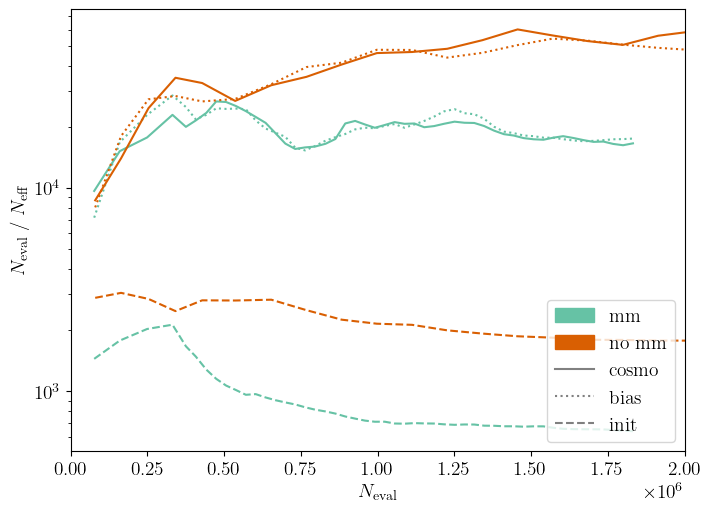

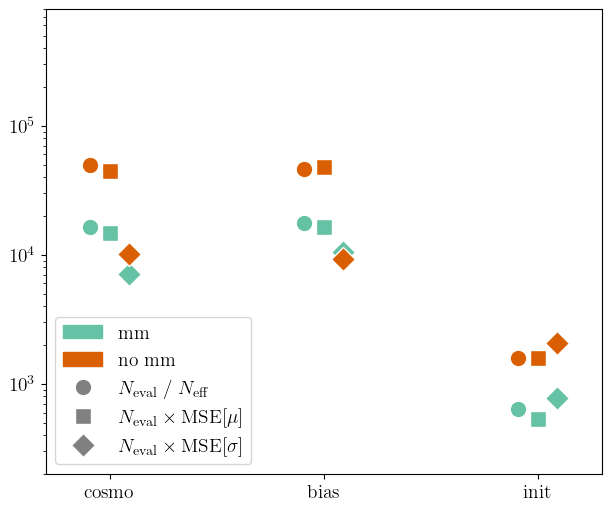

In [30]:
# Plot KDE, traj metrics, and final metrics
theme(usetex=True, font_size=14)

# gdplt = plots.get_subplot_plotter(width_inch=7)
# gdplt.settings.legend_fontsize = 20
# gdplt.settings.axes_labelsize = 20
# gdplt.settings.axes_fontsize = 12
# # gdplt.settings.figure_legend_frame = False
# # gdplt.settings.num_plot_contours = 3
# gdplt.triangle_plot(roots=gdsamps,
#                 # title_limit=1,
#                 filled=True, 
#                 markers=truth,
#                 contour_colors=[SetDark2(i) for i in range(len(gdsamps))],
#                 legend_loc='upper right',)
# plt.savefig(pfx+'triangle.pdf')

plt.figure(figsize=(7, 5), layout="constrained")
plot_traj_fn(metrics, labels)
plt.xlim(0,2e6)
plt.savefig(pfx+'cumess.pdf')

plt.figure(figsize=(6, 5), layout="constrained")
plot_fin_fn(fin_metrics, labels)
plt.ylim((2*1e2, 8*1e5))
plt.savefig(pfx+'fin_metrics.pdf')

# Misc.

In [56]:
shape = (4,60)
jfn = jit(partial(model.predict, samples=shape))
params = jfn(jr.key(42))
params |= {"n_evals":jnp.ones(shape)}
jnp.savez(save_dir + "samples_0", **params)
params = jfn(jr.key(43))
params |= {"n_evals":jnp.ones(shape)}
jnp.savez(save_dir + "samples_1", **params)
params = jfn(jr.key(44))
params |= {"n_evals":jnp.ones(shape)}
jnp.savez(save_dir + "samples_2", **params)
save_path = save_dir+"samples"

/feynman/work/dphp/hs276503/envs/montenvtest3/lib/python3.12/site-packages/jax/_src/numpy/array_methods.py:66: UserWarning: Explicitly requested dtype <class 'jax.numpy.int64'> requested in astype is not available, and will be truncated to dtype int32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  return lax_numpy.astype(arr, dtype)
/feynman/work/dphp/hs276503/envs/montenvtest3/lib/python3.12/site-packages/jax/_src/numpy/array_methods.py:66: UserWarning: Explicitly requested dtype <class 'jax.numpy.int64'> requested in astype is not available, and will be truncated to dtype int32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  return lax_numpy.astype(arr, dtype)


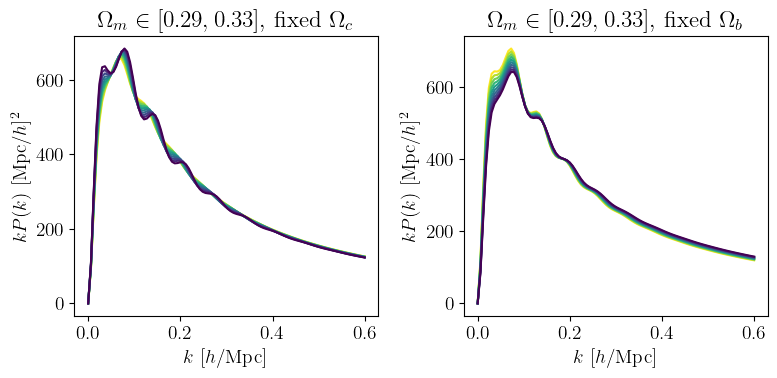

In [30]:
from montecosmo.bricks import Planck18
from montecosmo.plot import plot_pow
import jax_cosmo as jc

n = 10
a = 1.
log = False
ks = jnp.linspace(0, 0.6, 100)
pk_fn = jit(partial(jc.power.linear_matter_power, k=ks, a=a))
Oms = np.linspace(0.29, 0.33, n)

plt.figure(figsize=(8, 4))
plt.subplot(121)
plt.title("$\\Omega_m \\in [0.29, 0.33]$, fixed $\\Omega_c$")
for i_c, Om in enumerate(Oms):
    cmap = plt.get_cmap('viridis_r', n)
    cosmo = Planck18(Omega_b=Om - Planck18().Omega_c)
    pk = pk_fn(cosmo)
    plot_pow(ks, pk, log=log, color=cmap(i_c))

plt.subplot(122)
plt.title("$\\Omega_m \\in [0.29, 0.33]$, fixed $\\Omega_b$")
for i_c, Om in enumerate(Oms):
    cmap = plt.get_cmap('viridis_r', n)
    cosmo = Planck18(Omega_c=Om - Planck18().Omega_b)
    pk = pk_fn(cosmo)
    plot_pow(ks, pk, log=log, color=cmap(i_c))
plt.tight_layout()